# Recurrent Nerual Network for weather forecast

Some of interesting models, which are listed below, from the book, **Deep Learning with Python by Francois Chollet** were taken.

* Gated Recurrent Unit (GRU)
* GRU with dropouts 
* Stacking GRU layers

In [1]:
import os
import numpy as np

import keras
keras.__version__

Using TensorFlow backend.


'2.2.4'

In [2]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

import seaborn as sns

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

font      = {'family':'arial', 'style':'normal', 'size':18}
axis_font = {'family':'arial', 'style':'normal', 'size':18}
plt.rc('font', **font)

### Data preparation

* Data: [jena_climate](https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip)

* This step primarily contains following steps:
    1. Data parsing
    2. Normalization
    3. Data generation for modeling

### 1. Loading the downloaded data into numpy array

In [3]:
data_dir = '../data'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print("INFO: # of columns: {}".format(len(header)))
print("INFO: {}".format(", ".join(header)))

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    #print("Coding: ", float_data.shape, len(values))
    float_data[i, :len(values)] = values

print("INFO: array shape {}".format(float_data.shape))

INFO: # of columns: 15
INFO: "Date Time", "p (mbar)", "T (degC)", "Tpot (K)", "Tdew (degC)", "rh (%)", "VPmax (mbar)", "VPact (mbar)", "VPdef (mbar)", "sh (g/kg)", "H2OC (mmol/mol)", "rho (g/m**3)", "wv (m/s)", "max. wv (m/s)", "wd (deg)"
INFO: array shape (420552, 14)


### 2. Normalizing the data

In [4]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean

std = float_data[:200000].std(axis=0)
float_data /= std

### 3. Creating generator for fitting Keras model

In [5]:
def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

In [6]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step, 
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# This is how many steps to draw from `val_gen`
# in order to see the whole validation set:
val_steps = (300000 - 200001 - lookback) // batch_size

# This is how many steps to draw from `test_gen`
# in order to see the whole test set:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

### Keras Models

1. Gated Recurrent Unit (GRU)
2. GRU with dropouts 
3. Stacking GRU layers

### 1. Gated Recurrent Unit (GRU)

In [7]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

gru_model = Sequential()
gru_model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
gru_model.add(layers.Dense(1))

gru_model.compile(optimizer=RMSprop(), loss='mae')
gru_model.summary()
gru_loss_history_1 = gru_model.fit_generator(train_gen,
                                          steps_per_epoch=500,
                                          epochs=20,
                                          validation_data=val_gen,
                                          validation_steps=val_steps)

W0821 10:09:39.523544 139970285811520 deprecation_wrapper.py:119] From /home/rojan/Kathmandu/Virtual/env/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 10:09:39.551859 139970285811520 deprecation_wrapper.py:119] From /home/rojan/Kathmandu/Virtual/env/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 10:09:39.571938 139970285811520 deprecation_wrapper.py:119] From /home/rojan/Kathmandu/Virtual/env/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0821 10:09:39.711449 139970285811520 deprecation_wrapper.py:119] From /home/rojan/Kathmandu/Virtual/env/lib64/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


W0821 10:09:40.158993 139970285811520 deprecation_wrapper.py:119] From /home/rojan/Kathmandu/Virtual/env/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0821 10:09:40.164559 139970285811520 deprecation_wrapper.py:119] From /home/rojan/Kathmandu/Virtual/env/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/20
500/500 [==============================] - 72s 144ms/step - loss: 0.3016 - val_loss: 0.2779
Epoch 2/20
500/500 [==============================] - 79s 158ms/step - loss: 0.2850 - val_loss: 0.2641
Epoch 3/20
500/500 [==============================] - 78s 156ms/step - loss: 0.2773 - val_loss: 0.2620
Epoch 4/20
500/500 [==============================] - 77s 154ms/step - loss: 0.2736 - val_loss: 0.2607
Epoch 5/20
500/500 [==============================] - 79s 158ms/step - loss: 0.2695 - val_loss: 0.2612
Epoch 6/20
500/500 [==============================] - 79s 158ms/step - loss: 0.2657 - val_loss: 0.2639
Epoch 7/20
500/500 [==============================] - 79s 157ms/step - loss: 0.2624 - val_loss: 0.2656
Epoch 8/20
500/500 [==============================] - 77s 155ms/step - loss: 0.2587 - val_loss: 0.2730
Epoch 9/20
500/500 [==============================] - 79s 157ms/step - loss: 0.2544 - val_loss: 0.2724
Epoch 10/20
500/500 [==============================] - 79s 158ms/step - l

W0821 10:35:41.188709 139970285811520 font_manager.py:1282] findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
W0821 10:35:41.356507 139970285811520 font_manager.py:1282] findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.
W0821 10:35:41.366945 139970285811520 font_manager.py:1282] findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


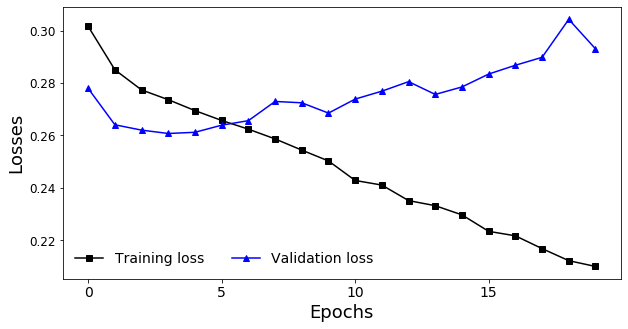

In [8]:
ts_tra_loss = gru_loss_history_1.history['loss']
ts_val_loss = gru_loss_history_1.history['val_loss']

ts_in_epochs = np.arange(0, len(ts_tra_loss))
fig = plt.figure(figsize=(10, 5))

plt.plot(ts_in_epochs, ts_tra_loss, 's-', color="k", label='Training loss')
plt.plot(ts_in_epochs, ts_val_loss, '^-', color="b", label='Validation loss')

ts_xlabels = np.arange(0, len(ts_in_epochs), 5)
plt.xticks(ts_xlabels, ts_xlabels, fontsize=14)

plt.xlabel("Epochs", axis_font)
plt.ylabel("Losses", axis_font)
plt.legend(ncol=2, frameon=False, fontsize=14)

plt.show()

### 2. GRU with dropouts 

In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

gru_drop_model = Sequential()
gru_drop_model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
gru_drop_model.add(layers.Dense(1))

gru_drop_model.compile(optimizer=RMSprop(), loss='mae')
gru_drop_model.summary()
gru_loss_history_2 = gru_drop_model.fit_generator(train_gen,
                                              steps_per_epoch=500,
                                              epochs=40,
                                              validation_data=val_gen,
                                              validation_steps=val_steps)

W0821 10:35:41.566439 139970285811520 deprecation.py:506] From /home/rojan/Kathmandu/Virtual/env/lib64/python3.6/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
500/500 [==============================] - 90s 179ms/step - loss: 0.3438 - val_loss: 0.2752
Epoch 2/40
500/500 [==============================] - 88s 176ms/step - loss: 0.3151 - val_loss: 0.2694
Epoch 3/40
500/500 [==============================] - 87s 175ms/step - loss: 0.3093 - val_loss: 0.2707
Epoch 4/40
500/500 [==============================] - 89s 177ms/step - loss: 0.3042 - val_loss: 0.2695
Epoch 5/40
500/500 [==============================] - 89s 178ms/step - loss: 0.3009 - val_loss: 0.2689
Epoch 6/40
500/500 [=

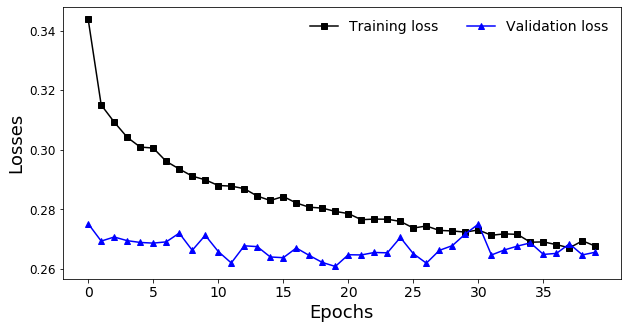

In [10]:
ts_tra_loss = gru_loss_history_2.history['loss']
ts_val_loss = gru_loss_history_2.history['val_loss']

ts_in_epochs = np.arange(0, len(ts_tra_loss))
fig = plt.figure(figsize=(10, 5))

plt.plot(ts_in_epochs, ts_tra_loss, 's-', color="k", label='Training loss')
plt.plot(ts_in_epochs, ts_val_loss, '^-', color="b", label='Validation loss')

ts_xlabels = np.arange(0, len(ts_in_epochs), 5)
plt.xticks(ts_xlabels, ts_xlabels, fontsize=14)

plt.xlabel("Epochs", axis_font)
plt.ylabel("Losses", axis_font)
plt.legend(ncol=2, frameon=False, fontsize=14)

plt.show()

### 3. Stacking GRU layers

In [11]:
# stacking recurrent layers

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

stack_gru_drop_model = Sequential()
stack_gru_drop_model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
stack_gru_drop_model.add(layers.GRU(64, activation='relu',
                     dropout=0.1, 
                     recurrent_dropout=0.5))
stack_gru_drop_model.add(layers.Dense(1))

stack_gru_drop_model.compile(optimizer=RMSprop(), loss='mae')
gru_loss_history_3 = stack_gru_drop_model.fit_generator(train_gen,
                                                  steps_per_epoch=500,
                                                  epochs=40,
                                                  validation_data=val_gen,
                                                  validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 200s 400ms/step - loss: 0.3376 - val_loss: 0.2778
Epoch 2/40
500/500 [==============================] - 197s 393ms/step - loss: 0.3133 - val_loss: 0.2709
Epoch 3/40
500/500 [==============================] - 199s 398ms/step - loss: 0.3073 - val_loss: 0.2676
Epoch 4/40
500/500 [==============================] - 198s 396ms/step - loss: 0.3027 - val_loss: 0.2678
Epoch 5/40
500/500 [==============================] - 197s 394ms/step - loss: 0.2968 - val_loss: 0.2704
Epoch 6/40
500/500 [==============================] - 198s 397ms/step - loss: 0.2946 - val_loss: 0.2717
Epoch 7/40
500/500 [==============================] - 199s 397ms/step - loss: 0.2907 - val_loss: 0.2688
Epoch 8/40
500/500 [==============================] - 198s 395ms/step - loss: 0.2884 - val_loss: 0.2675
Epoch 9/40
500/500 [==============================] - 196s 392ms/step - loss: 0.2882 - val_loss: 0.2759
Epoch 10/40
500/500 [==============================] - 198s 396m

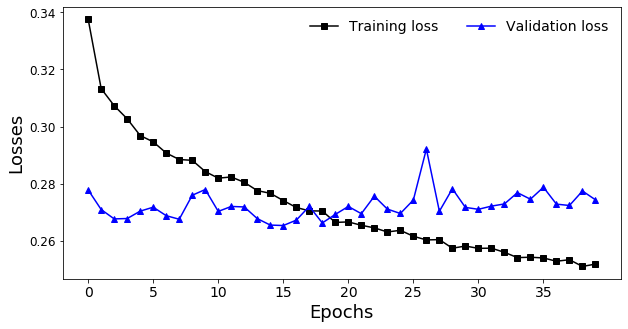

In [12]:
ts_tra_loss = gru_loss_history_3.history['loss']
ts_val_loss = gru_loss_history_3.history['val_loss']

ts_in_epochs = np.arange(0, len(ts_tra_loss))
fig = plt.figure(figsize=(10, 5))

plt.plot(ts_in_epochs, ts_tra_loss, 's-', color="k", label='Training loss')
plt.plot(ts_in_epochs, ts_val_loss, '^-', color="b", label='Validation loss')

ts_xlabels = np.arange(0, len(ts_in_epochs), 5)
plt.xticks(ts_xlabels, ts_xlabels, fontsize=14)

plt.xlabel("Epochs", axis_font)
plt.ylabel("Losses", axis_font)
plt.legend(ncol=2, frameon=False, fontsize=14)

plt.show()

In [13]:
fo_gru_model = gru_model.evaluate_generator(test_gen, test_steps)
print("INFO: GRU: %5.3f" %fo_gru_model)
fo_gru_model = gru_drop_model.evaluate_generator(test_gen, test_steps)
print("INFO: GRU with drop: %5.3f" %fo_gru_model)
fo_gru_model = stack_gru_drop_model.evaluate_generator(test_gen, test_steps)
print("INFO: Stack GRUs with drop: %5.3f" %fo_gru_model)

INFO: GRU: 0.305
INFO: GRU with drop: 0.280
INFO: Stack GRUs with drop: 0.282


### Summary

* GRU achieved ~0.26 loss on validation dataset (0.31 on test set) but the model is affected by overfitting. 
* With drop out including recurrent dropout, GRU showed a covergence between training loss and validation loss after 30 epochs. The performance on test dataset was slightly improved.
* Multi-layer GRUs also showed similar performance (0.28) on test dataset as GRU with dropout. For few epochs between 15 to 25, the loss values are similar but they are again diverged with increasing epochs.

### Can good fit model be generated?